In [1]:
%load_ext autoreload

In [10]:
%autoreload

In [3]:
import random

import numpy as np
import torch
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
import matplotlib.pyplot as plt

from autoencoder import Autoencoder
from callbacks import GenerateCallback
from dataset import DirImagesDataset

In [4]:
minecraft_dataset = DirImagesDataset(
    '../data/minecraft_images/train',
    cache_path='.cache/minecraft_dataset',
    target=0.0,
    size=64,
)

loading images from dataset


  0%|          | 0/10405 [00:00<?, ?it/s]

100%|██████████| 10405/10405 [00:14<00:00, 718.38it/s]


In [5]:
test_dataset = DirImagesDataset(
    '../data/minecraft_images/test',
    target=0.0,
    size=64,
)

loading images from dataset


100%|██████████| 10/10 [00:00<00:00, 502.80it/s]


In [6]:
real_dataset = DirImagesDataset(
    '../data/real_images',
    cache_path='.cache/real_dataset',
    target=1.0,
    size=64,
)

loading cached images


In [6]:
dataset = real_dataset
for i in range(9):
    dataset += minecraft_dataset

print('Dataset size:', len(dataset))

Dataset size: 183645


In [7]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True,
    num_workers=1,
)

In [8]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256)

In [9]:
test_images = []
for _ in range(1):
    idx = random.randint(0, len(test_dataset)-1)
    test_images.append(test_dataset[idx][0])
test_images = np.array(test_images)

generate_callback = GenerateCallback(test_images, every_n_epochs=1)

In [10]:
trainer = Trainer(
    accelerator="cuda",
    max_epochs=-1,
    callbacks=[generate_callback]
)

trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(autoencoder, dataloader)

/home/lklimkiewicz/stud/gsn/minecraft/workspace_autoencoder/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 3.4 M  | [2, 3, 64, 64] | [2, 256]      
1 | decoder | Decoder | 3.4 M  | [2, 256]       | [2, 3, 64, 64]
--------------------------------------------

Epoch 5:  69%|██████▉   | 993/1435 [00:32<00:14, 30.50it/s, v_num=1] 

/home/lklimkiewicz/stud/gsn/minecraft/workspace_autoencoder/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Test autoencoder

In [7]:
autoencoder = Autoencoder.load_from_checkpoint('checkpoints/checkpoint.ckpt')

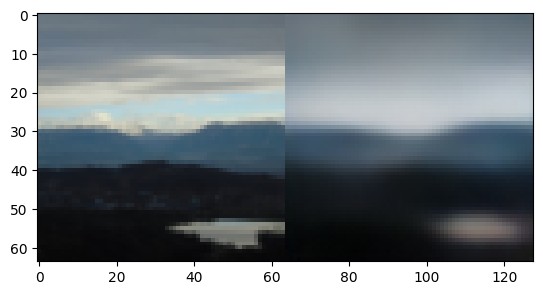

In [21]:
# test on real images
idx = random.randint(0, len(real_dataset)-1)
img = np.transpose(real_dataset[idx][0] + 0.5, [1, 2, 0])
real_img = autoencoder.predict(img)
joined = np.concatenate([img, real_img], axis=1)
plt.imshow(joined)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


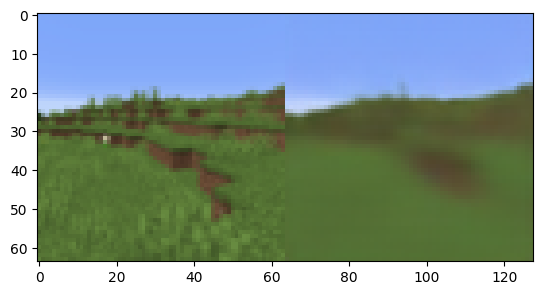

In [41]:
# test on minecraft train images
idx = random.randint(0, len(minecraft_dataset)-1)
img = np.transpose(minecraft_dataset[idx][0] + 0.5, [1, 2, 0])
real_img = autoencoder.predict(img)
joined = np.concatenate([img, real_img], axis=1)
plt.imshow(joined)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


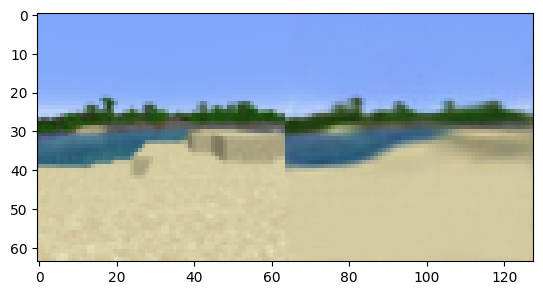

In [43]:
# test on minecraft test images
idx = random.randint(0, len(test_dataset)-1)
img = np.transpose(test_dataset[idx][0] + 0.5, [1, 2, 0])
real_img = autoencoder.predict(img)
joined = np.concatenate([img, real_img], axis=1)
plt.imshow(joined)